<a href="https://colab.research.google.com/github/Kim-matthew-0422/deeplearning-early-covid-detection-/blob/main/covid_detections(cnn_and_VGG19).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c3a668f1-c7ff-2a1f-8a71-146c80468477)


In [2]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
from google.colab import files
import termios
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"etkim422","key":"ba5083a771515c1999a723e17e69eb58"}'}

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

covid19-radiography-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

--2023-01-26 07:29:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-26 07:29:10 (113 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [7]:
from sklearn.model_selection import train_test_split

In [8]:
unzip_data('covid19-radiography-database.zip')

In [9]:
path = 'COVID-19_Radiography_Dataset'
levels = ['Normal/images', 'COVID/images']

In [10]:
import os
data_dir = os.path.join(path) 

In [11]:
data_dir

'COVID-19_Radiography_Dataset'

In [12]:
import pandas as pd

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])
data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])


In [13]:
data

image_file  corona_result
0      Normal/images/Normal-1069.png  Normal/images
1      Normal/images/Normal-9632.png  Normal/images
2       Normal/images/Normal-957.png  Normal/images
3      Normal/images/Normal-3188.png  Normal/images
4      Normal/images/Normal-1157.png  Normal/images
...                              ...            ...
13803    COVID/images/COVID-1817.png   COVID/images
13804    COVID/images/COVID-1209.png   COVID/images
13805     COVID/images/COVID-706.png   COVID/images
13806    COVID/images/COVID-1220.png   COVID/images
13807    COVID/images/COVID-3222.png   COVID/images

[13808 rows x 2 columns]

In [14]:
data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal/images': 'Negative', 'COVID/images': 'Positive'})
samples = 13808

data.head()

image_file corona_result  \
0  Normal/images/Normal-1069.png      Negative   
1  Normal/images/Normal-9632.png      Negative   
2   Normal/images/Normal-957.png      Negative   
3  Normal/images/Normal-3188.png      Negative   
4  Normal/images/Normal-1157.png      Negative   

                                                path  
0  COVID-19_Radiography_Dataset/Normal/images/Nor...  
1  COVID-19_Radiography_Dataset/Normal/images/Nor...  
2  COVID-19_Radiography_Dataset/Normal/images/Nor...  
3  COVID-19_Radiography_Dataset/Normal/images/Nor...  
4  COVID-19_Radiography_Dataset/Normal/images/Nor...

In [15]:
data.duplicated().sum()

0

In [16]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame()
df['corona_result'] = ['Positive', 'Negative']
df['Count'] = [len(data[data['corona_result'] == 'Positive']), len(data[data['corona_result'] == 'Negative'])]
df = df.sort_values(by = ['Count'], ascending = False)

fig = px.bar(df, x = 'corona_result', y = 'Count', 
             color = "corona_result", text_auto='', width = 600, 
             color_discrete_sequence = ["orange", "purple"],
             template = 'plotly_dark')

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()

In [17]:
df.head()

corona_result  Count
1      Negative  10192
0      Positive   3616

In [18]:
import numpy as np
from keras.preprocessing import image
from PIL import Image
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

data.head()

image_file corona_result  \
0  Normal/images/Normal-1069.png      Negative   
1  Normal/images/Normal-9632.png      Negative   
2   Normal/images/Normal-957.png      Negative   
3  Normal/images/Normal-3188.png      Negative   
4  Normal/images/Normal-1157.png      Negative   

                                                path  \
0  COVID-19_Radiography_Dataset/Normal/images/Nor...   
1  COVID-19_Radiography_Dataset/Normal/images/Nor...   
2  COVID-19_Radiography_Dataset/Normal/images/Nor...   
3  COVID-19_Radiography_Dataset/Normal/images/Nor...   
4  COVID-19_Radiography_Dataset/Normal/images/Nor...   

                                               image  
0  [[0, 0, 0, 0, 3, 34, 51, 66, 81, 91, 98, 97, 9...  
1  [[5, 4, 4, 4, 3, 4, 3, 3, 3, 2, 2, 1, 1, 1, 1,...  
2  [[69, 45, 49, 55, 56, 58, 59, 57, 53, 47, 40, ...  
3  [[10, 10, 7, 5, 3, 11, 17, 19, 25, 26, 29, 33,...  
4  [[29, 46, 61, 66, 90, 118, 109, 109, 115, 127,...

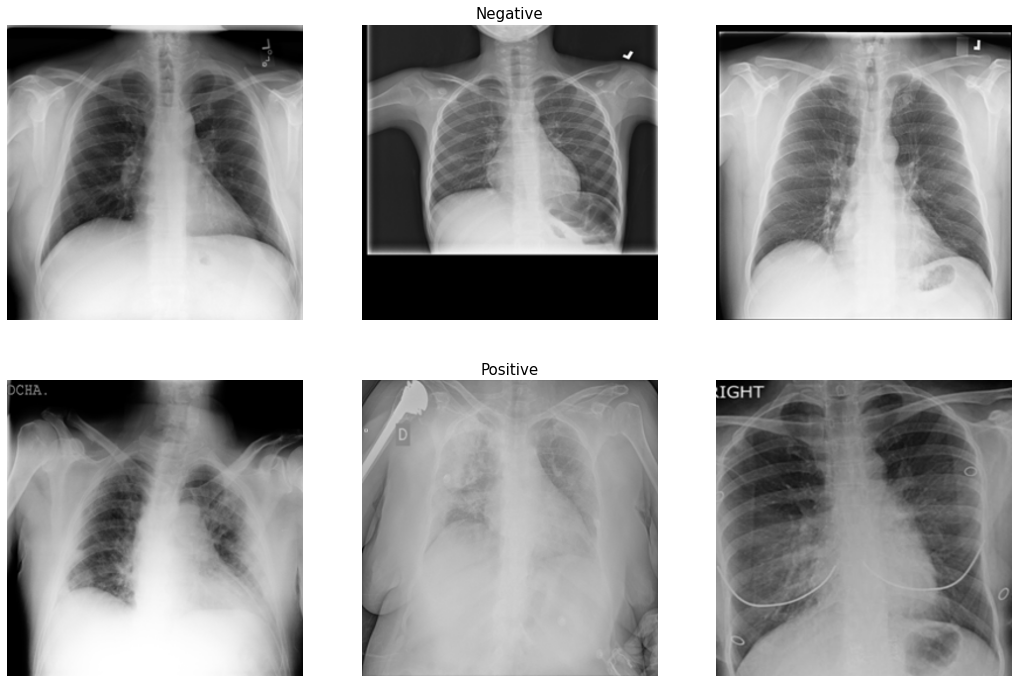

In [19]:
import cv2
n_samples = 3

fig, m_axs = plt.subplots(2, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['corona_result']).groupby('corona_result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

In [20]:
m_axs

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8511d92b0>,
      dtype=object)

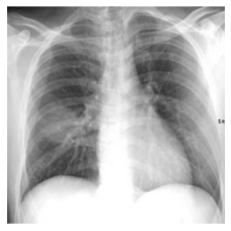

In [21]:
plt.figure()
image = cv2.imread("COVID-19_Radiography_Dataset/COVID/images/COVID-1002.png")
plt.imshow(image)
plt.axis('off')
plt.show() 

In [22]:
print('Image Shape: {}'.format(image.shape))
print('Image Height: {}'.format(image.shape[0]))
print('Image Width: {}'.format(image.shape[1]))
print('Image Dimension: {}'.format(image.ndim))
print('Image Size: {}kb'.format(image.size//1024))
print('Image Data Type: {}'.format(image.dtype))
print('Maximum RGB value of the image: {}'.format(image.max()))
print('Minimum RGB value of the image: {}'.format(image.min()))

Image Shape: (299, 299, 3)
Image Height: 299
Image Width: 299
Image Dimension: 3
Image Size: 261kb
Image Data Type: uint8
Maximum RGB value of the image: 255
Minimum RGB value of the image: 5


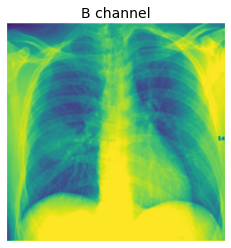

In [23]:
plt.title('B channel', fontsize = 14)
plt.imshow(image[ : , : , 0])
plt.axis('off');
plt.show()

First, we convert the images to greyscale and then apply Gaussian blur to them.

In [24]:
all_covid = []
all_normal = []
import random
from glob import glob
all_normal.extend(glob(os.path.join(path, 'Normal/images/*.png')))
all_covid.extend(glob(os.path.join(path, 'COVID/images/*.png')))

random.shuffle(all_normal)
random.shuffle(all_covid)

images = all_normal[:50] + all_covid[:50]

In [25]:
images

['COVID-19_Radiography_Dataset/Normal/images/Normal-5058.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-5720.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-5163.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-4078.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-8751.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-9514.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-6654.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-8559.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-8503.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-9759.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-2101.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-1463.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-2731.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-2213.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-9968.png',
 'COVID-19_Radiography_Dataset/Normal/images/Normal-961

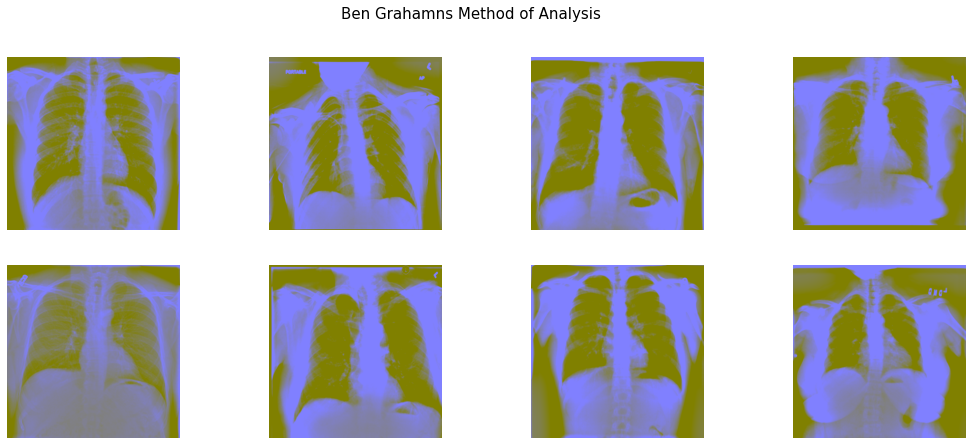

In [26]:
fig = plt.figure(figsize = (18, 7))
fig.suptitle("Ben Grahamns Method of Analysis", fontsize = 15)
columns = 4; rows = 2

for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

albumentations

In [27]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):

  fig,  myaxes = plt.subplots(figsize = (15,8), nrows = 2, ncols = ncols, squeeze = False)
  fig.suptitle(main_title, fontsize = 18)
  fig.subplots_adjust(wspace = 0.3)
  fig.subplots_adjust(hspace = 0.3)

  for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
    myaxes[i // ncols][i % ncols].imshow(img)
    myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
  plt.show()  

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning:

This class has been deprecated. Please use RandomBrightnessContrast

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1639: FutureWarning:

RandomContrast has been deprecated. Please use RandomBrightnessContrast



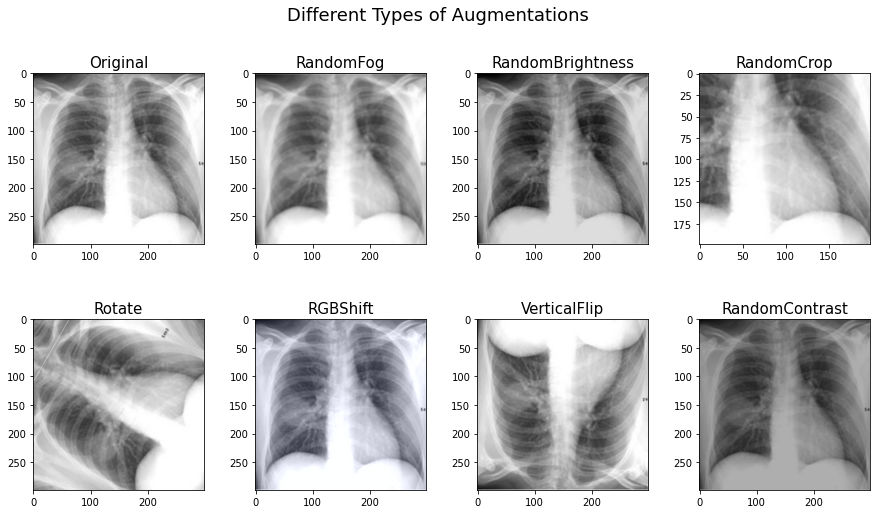

In [28]:
import albumentations as A
chosen_image = cv2.imread('COVID-19_Radiography_Dataset/COVID/images/COVID-1002.png')
albumentation_list = [A.RandomFog(p = 1), A.RandomBrightness(p = 1),
                      A.RandomCrop(p = 1,height = 199, width = 199), A.Rotate(p = 1, limit = 90),
                      A.RGBShift(p = 1), A.VerticalFlip(p = 1), A.RandomContrast(limit = 0.5, p = 1)]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original", "RandomFog", "RandomBrightness", "RandomCrop", "Rotate", "RGBShift", "VerticalFlip", "RandomContrast"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 4, main_title = "Different Types of Augmentations")

image value distribution

In [29]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0, samples):
  mean_val.append(data['image'][i].mean())
  std_dev_val.append(np.std(data['image'][i]))
  max_val.append(data['image'][i].max())
  min_val.append(data['image'][i].min())

imageEDA = data.loc[:,['image', 'corona_result','path']]
imageEDA['mean'] = mean_val
imageEDA['stddev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

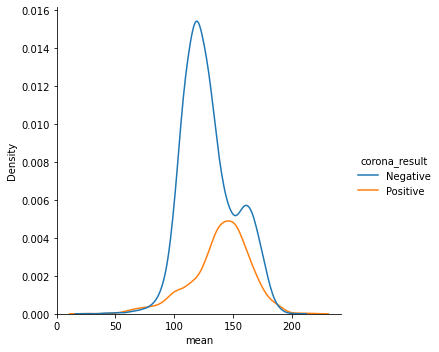

In [30]:
ax1 = sns.displot(data = imageEDA, x = 'mean', kind = 'kde', hue = 'corona_result')

spliting process

In [31]:
all_data = []


for i in range(len(data)):
  image = cv2.imread(data['path'][i])
  image = cv2.resize(image, (70,70)) / 255.0
  label = 1 if data['corona_result'][i] == 'Positive' else 0 
  all_data.append([image, label])

In [32]:
all_data

[[array([[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.52156863, 0.52156863, 0.52156863],
          [0.30980392, 0.30980392, 0.30980392],
          [0.3254902 , 0.3254902 , 0.3254902 ]],
  
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.58431373, 0.58431373, 0.58431373],
          [0.32156863, 0.32156863, 0.32156863],
          [0.3254902 , 0.3254902 , 0.3254902 ]],
  
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.51764706, 0.51764706, 0.51764706],
          [0.3254902 , 0.3254902 , 0.3254902 ],
          [0.32156863, 0.32156863, 0.32156863]],
  
         ...,
  
         [[0.11764706, 0.11764706, 0.11764706],
          [0.3

In [33]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(9941, 70, 70, 3) (2762, 70, 70, 3) (1105, 70, 70, 3) (9941,) (2762,) (1105,)


CNN model


In [34]:
from tensorflow.keras import layers, models
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', input_shape = (70,70,3)))
cnn_model.add(layers.MaxPooling2D((2,2)))
cnn_model.add(layers.Dropout(0.3))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2,2)))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units = 16, activation = 'relu'))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(units = 2))

In [35]:
import tensorflow as tf

cnn_model.compile(optimizer = 'adam',
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                  metrics = ['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 34, 34, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [36]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

#tf.random.set_seed(42)
history = cnn_model.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [es])

Epoch 1/50
39/39 [==============================] - 14s 150ms/step - loss: 0.6145 - accuracy: 0.7206 - val_loss: 0.5740 - val_accuracy: 0.7638
Epoch 2/50
39/39 [==============================] - 4s 108ms/step - loss: 0.5202 - accuracy: 0.7330 - val_loss: 0.4814 - val_accuracy: 0.7638
Epoch 3/50
39/39 [==============================] - 4s 104ms/step - loss: 0.4833 - accuracy: 0.7327 - val_loss: 0.4463 - val_accuracy: 0.7638
Epoch 4/50
39/39 [==============================] - 4s 104ms/step - loss: 0.4482 - accuracy: 0.7557 - val_loss: 0.3830 - val_accuracy: 0.8290
Epoch 5/50
39/39 [==============================] - 4s 105ms/step - loss: 0.4016 - accuracy: 0.8127 - val_loss: 0.3598 - val_accuracy: 0.8661
Epoch 6/50
39/39 [==============================] - 4s 106ms/step - loss: 0.3598 - accuracy: 0.8526 - val_loss: 0.3119 - val_accuracy: 0.8796
Epoch 7/50
39/39 [==============================] - 4s 105ms/step - loss: 0.3285 - accuracy: 0.8743 - val_loss: 0.2933 - val_accuracy: 0.8950
Epoch

In [37]:
yp_train = cnn_model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = cnn_model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = cnn_model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

87/87 [==============================] - 0s 6ms/step


In [38]:
def evaluation_parametrics(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Recall on Train Data: ", round(recall_score(y_train, yp_train),4))
    print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train),4))
    print("Precision on Train Data: ", round(precision_score(y_train, yp_train),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train),4))
    print("--------------------------------------------------------------------------")
       
    cm_val = confusion_matrix(y_val, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val)
    s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")
    print("Recall on Val Data: ", round(recall_score(y_val, yp_val),4))
    print("Specificity on Val Data: ", s2)
    print("Accuracy on Val Data: ", round(accuracy_score(y_val, yp_val),4))
    print("Precision on Val Data: ", round(precision_score(y_val, yp_val),4))
    print("F1 Score on Val Data: ", round(f1_score(y_val, yp_val),4))
    print("--------------------------------------------------------------------------")

    cm_test = confusion_matrix(y_test, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Recall on Test Data: ", round(recall_score(y_test, yp_test), 4))
    print("Specificity on Test Data: ", s3)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
    print("Precision on Test Data: ", round(precision_score(y_test, yp_test), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()   
    t3.plot()


-----------------------------Convolution Neural Network-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7287
           1       0.97      0.97      0.97      2654

    accuracy                           0.99      9941
   macro avg       0.98      0.98      0.98      9941
weighted avg       0.99      0.99      0.99      9941

--------------------------------------------------------------------------
Recall on Train Data:  0.9729
Specificity on Train Data:  0.9901
Accuracy on Train Data:  0.9855
Precision on Train Data:  0.9729
F1 Score on Train Data:  0.9729
--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       844
           1       0.89      0.92      0.91       261

    accuracy                

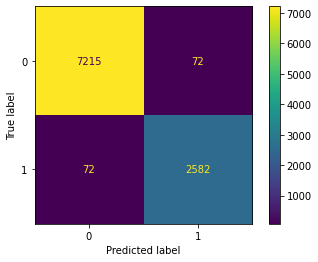

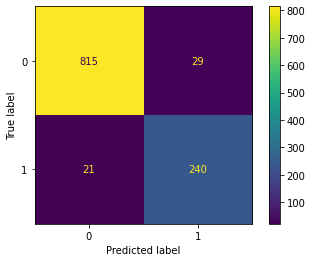

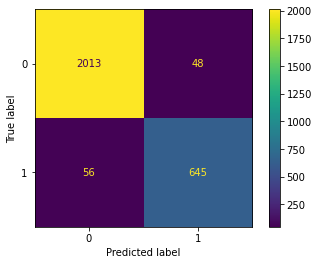

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score
evaluation_parametrics("Convolution Neural Network", y_train, yp_train, y_val, yp_val, y_test, yp_test)

In [40]:
# list all data in history

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


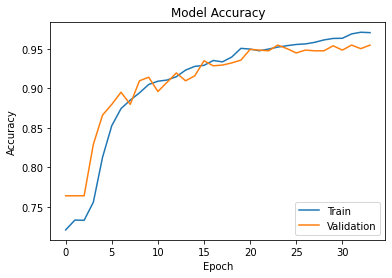

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

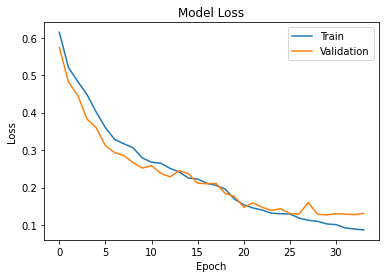

In [42]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

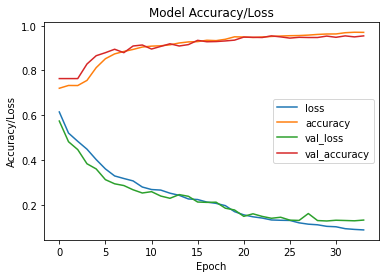

In [43]:
# Accuracy Loss Graph

pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

Checking to see if any transfer models can beat this.



In [44]:
from tensorflow.keras.applications.vgg19 import VGG19

In [45]:
base_model = VGG19(input_shape = (70,70, 3),
                   include_top = False)
base_model.trainable = False

In [46]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential



In [47]:
VGG_model = Sequential()

VGG_model.add(base_model)
VGG_model.add(layers.Flatten())
VGG_model.add(layers.Dense(units = 16, activation = 'relu'))
VGG_model.add(layers.Dropout(0.2))
VGG_model.add(layers.Dense(units = 2))

VGG_model.compile(optimizer = 'adam',
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                  metrics = ['accuracy'])

In [48]:
VGG_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 16)                32784     
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 20,057,202
Trainable params: 32,818
Non-trainable params: 20,024,384
_________________________________________________________________


In [49]:
history_VGG = VGG_model.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [es])

Epoch 1/50
39/39 [==============================] - 14s 282ms/step - loss: 0.5290 - accuracy: 0.7360 - val_loss: 0.4312 - val_accuracy: 0.8081
Epoch 2/50
39/39 [==============================] - 7s 180ms/step - loss: 0.4334 - accuracy: 0.7904 - val_loss: 0.3859 - val_accuracy: 0.8362
Epoch 3/50
39/39 [==============================] - 7s 181ms/step - loss: 0.4041 - accuracy: 0.8156 - val_loss: 0.3542 - val_accuracy: 0.8471
Epoch 4/50
39/39 [==============================] - 7s 181ms/step - loss: 0.3774 - accuracy: 0.8311 - val_loss: 0.3320 - val_accuracy: 0.8624
Epoch 5/50
39/39 [==============================] - 7s 181ms/step - loss: 0.3559 - accuracy: 0.8448 - val_loss: 0.3211 - val_accuracy: 0.8624
Epoch 6/50
39/39 [==============================] - 7s 180ms/step - loss: 0.3423 - accuracy: 0.8477 - val_loss: 0.3105 - val_accuracy: 0.8688
Epoch 7/50
39/39 [==============================] - 7s 180ms/step - loss: 0.3268 - accuracy: 0.8594 - val_loss: 0.2950 - val_accuracy: 0.8814
Epoch

In [50]:
Vyp_train = VGG_model.predict(x_train)
Vyp_train = np.argmax(Vyp_train, axis = 1)

Vyp_val = VGG_model.predict(x_val)
Vyp_val = np.argmax(Vyp_val, axis = 1)

Vyp_test = VGG_model.predict(x_test)
Vyp_test = np.argmax(Vyp_test, axis = 1)

87/87 [==============================] - 2s 28ms/step



-----------------------------Convolution Neural Network-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      7287
           1       0.88      0.93      0.90      2654

    accuracy                           0.95      9941
   macro avg       0.93      0.94      0.93      9941
weighted avg       0.95      0.95      0.95      9941

--------------------------------------------------------------------------
Recall on Train Data:  0.9258
Specificity on Train Data:  0.955
Accuracy on Train Data:  0.9472
Precision on Train Data:  0.8822
F1 Score on Train Data:  0.9035
--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       844
           1       0.80      0.86      0.83       261

    accuracy                 

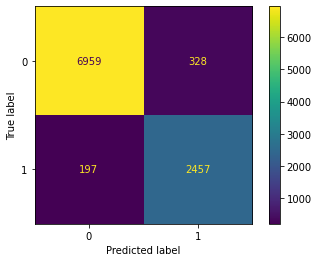

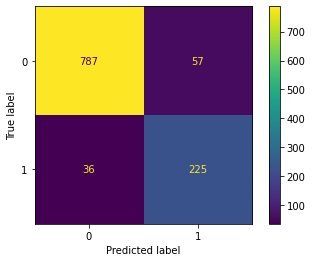

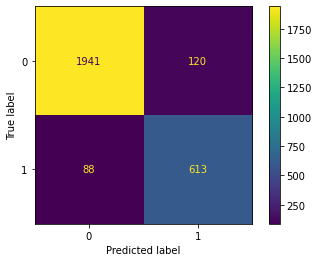

In [51]:
evaluation_parametrics("Convolution Neural Network", y_train, Vyp_train, y_val, Vyp_val, y_test, Vyp_test)

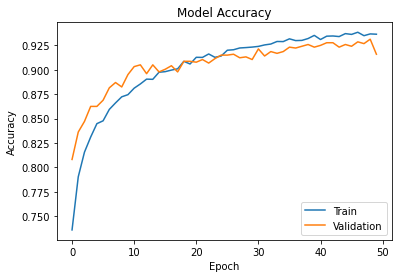

In [52]:
plt.plot(history_VGG.history['accuracy'])
plt.plot(history_VGG.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

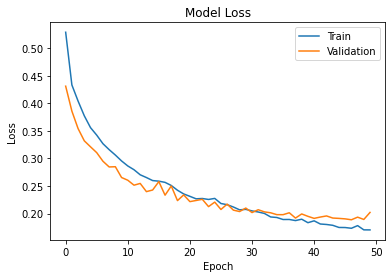

In [53]:
plt.plot(history_VGG.history['loss'])
plt.plot(history_VGG.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

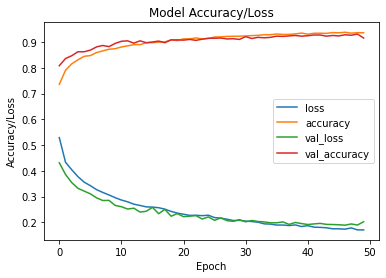

In [54]:
pd.DataFrame(history_VGG.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()